# Import

In [1]:
#import all libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV


#connect the google drive to download and upload data
from google.colab import drive
drive.mount('/content/drive')
#set the path to the drive data folder
directoryTrain = '/content/drive/MyDrive/MLFall2022/CurrentProject/data'
#directoryTest = '/content/drive/MyDrive/MLFall2022/CurrentProject/dataRF/test/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#configure the plots 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

#set the parameters
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

# Load

In [3]:
#load all the data
burnarea_combined = xr.open_dataset(os.path.join(directoryTrain, "burnarea_combined.nc"))
tmax = xr.open_dataset(os.path.join(directoryTrain, "tmax.nc"))
prec = xr.open_dataset(os.path.join(directoryTrain, "prec.nc"))
wind = xr.open_dataset(os.path.join(directoryTrain, "wind.nc"))

#data = xr.open_dataset(os.path.join(directoryTrain, "forest_type_frac.nc"))
#data = xr.open_dataset(os.path.join(directoryTrain, "epa_level2.nc"))
#data = xr.open_dataset(os.path.join(directoryTrain, "elevstd.nc"))
#data = xr.open_dataset(os.path.join(directoryTrain, "wui_distance.nc"))
#burnarea_combined = burnarea_combined.burnarea.loc[firsttime:finaltime]

#set the times for slicing
firsttime = "1984-01-15"
middletime = "2001-12-15"
middelstarttime = "2002-01-15"
finaltime = "2019-12-15"

#split the data to train and test before merging and stacking

#TRAIN SLICED DATA
print("TRAIN SLICED DATA")
burnarea_combined_train = burnarea_combined.sel(time=slice(firsttime, middletime))
print("burnarea_combined_train", burnarea_combined_train, "\n")

tmax_train = tmax.sel(time=slice(firsttime, middletime))
print("tmax_train", tmax_train, "\n")

### have to remove prec dataset, as it is not the same formet, has less rows than other datasets
#prec_train = prec.sel(time=slice(firsttime, middletime))
#print("prec_train", prec_train, "\n")

wind_train = wind.sel(time=slice(firsttime, middletime))
print("wind_train", wind_train, "\n")

print()

#TEST SLICED DATA
print("TEST SLICED DATA")
burnarea_combined_test = burnarea_combined.sel(time=slice(middelstarttime, finaltime))
print("burnarea_combined_test", burnarea_combined_test, "\n")

tmax_test = tmax.sel(time=slice(middelstarttime, finaltime))
print("tmax_test", tmax_test, "\n")

### have to remove prec dataset, as it is not the same formet, has less rows than other datasets
#prec_test = prec.sel(time=slice(middelstarttime, finaltime))
#print("prec_test", prec_test, "\n")

wind_test = wind.sel(time=slice(middelstarttime, finaltime))
print("wind_test", wind_test, "\n")


TRAIN SLICED DATA
burnarea_combined_train <xarray.Dataset>
Dimensions:   (X: 155, Y: 208, time: 216)
Coordinates:
  * X         (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y         (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time      (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2001-12-15
Data variables:
    burnarea  (time, Y, X) float32 ... 

tmax_train <xarray.Dataset>
Dimensions:  (X: 155, Y: 208, time: 216)
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time     (time) datetime64[ns] 1984-01-15 1984-02-15 ... 2001-12-15
Data variables:
    tmax     (time, Y, X) float32 ... 

wind_train <xarray.Dataset>
Dimensions:  (X: 155, Y: 208, time: 216)
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * ti

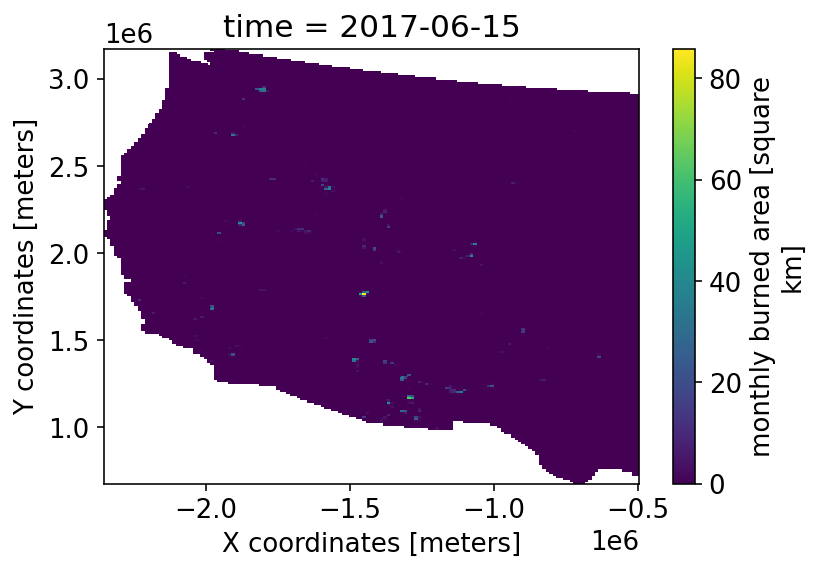

In [35]:
#print the plot as example
air = burnarea_combined["burnarea"]
air.isel(time=401).plot(x="X", y="Y")

In [5]:
### LAT = X and LONG = Y 

### MAIN FIX:
### Just like in any other models, we have different x and y data
### important to distinguish here
### therefore, we will have different train_files for x and y 

#Combining the Training set
train_files_y = [burnarea_combined_train]
train_files_x = [tmax_train]

X_all      = []
length_all = []
    
for ds in train_files_x:
  X_all.append(ds)
  length_all.append(len(ds.time))
    
X = xr.merge(X_all)
X = X.rename({'Y':'longitude','X': 'latitude'})
X = X.transpose('time', 'latitude', 'longitude') 
length_all = np.array(length_all)
X = X.assign_coords(time=np.arange(len(X.time)))
X_train_xr = X
X_length = length_all

Y_all = []
length_all = []
    
for dsy in train_files_y:
  Y_all.append(dsy)
  length_all.append(len(dsy.time))
    
length_all = np.array(length_all)
Y = xr.merge(Y_all)
Y = Y.rename({'Y':'longitude','X': 'latitude'})
Y = Y.transpose('time', 'latitude', 'longitude') 
Y = Y.assign_coords(time=np.arange(len(Y.time)))  
y_train_xr = Y 
y_length = length_all

#print the combined train data
print("X_train_xr", X_train_xr, "\n")
print("y_train_xr", y_train_xr, "\n")

X_train_xr <xarray.Dataset>
Dimensions:    (latitude: 155, longitude: 208, time: 216)
Coordinates:
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
Data variables:
    tmax       (time, latitude, longitude) float32 ... 

y_train_xr <xarray.Dataset>
Dimensions:    (latitude: 155, longitude: 208, time: 216)
Coordinates:
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
Data variables:
    burnarea   (time, latitude, longitude) float32 ... 



In [6]:
#Combining the Testing set

test_files_y = [burnarea_combined_test]
test_files_x = [tmax_test]

X_all      = []
length_all = []
    
for ds in test_files_x:
  X_all.append(ds)
  length_all.append(len(ds.time))

X = xr.merge(X_all)
X = X.rename({'Y':'longitude','X': 'latitude'})
X = X.transpose('time', 'latitude', 'longitude') 
length_all = np.array(length_all)
X = X.assign_coords(time=np.arange(len(X.time)))
X_test_xr = X
X_length = length_all

Y_all = []
length_all = []
    
for dsy in test_files_y:
  Y_all.append(dsy)
  length_all.append(len(dsy.time))
    
length_all = np.array(length_all)
Y = xr.merge(Y_all)
Y = Y.rename({'Y':'longitude','X': 'latitude'})
Y = Y.transpose('time', 'latitude', 'longitude') 
Y = Y.assign_coords(time=np.arange(len(Y.time))) 
y_test_xr = Y 
y_length = length_all

#print the combined train data
print("X_test_xr", X_test_xr, "\n")
print("y_test_xr", y_test_xr, "\n")

X_test_xr <xarray.Dataset>
Dimensions:    (latitude: 155, longitude: 208, time: 216)
Coordinates:
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
Data variables:
    tmax       (time, latitude, longitude) float32 ... 

y_test_xr <xarray.Dataset>
Dimensions:    (latitude: 155, longitude: 208, time: 216)
Coordinates:
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
Data variables:
    burnarea   (time, latitude, longitude) float32 ... 



In [7]:
#change to dataframe
#here we are working with multidimentional data, therefore, we have a very big data set (5168016 rows)
#we had to remove prec dataset, as it was producing uneven data sets or x_train and y_train

#X_train_df = X_train_xr.to_dataframe().dropna()
#X_test_df  = X_test_xr.to_dataframe().dropna()
#y_train_df = y_train_xr.to_dataframe().dropna()

#print(X_train_df, "\n")
#print(X_test_df, "\n")
#print(y_train_df, "\n")

#however in order to be able to bring the data back into a dataset we need to dataframe it differently 
#conserving the lat, long, and time coordinates 

In [8]:
#another way to make data into a dataframe
X_train_df = X_train_xr["tmax"].stack(dim=["latitude", "longitude"])
X_train_df = pd.DataFrame(X_train_df.to_pandas())
#replace all NaN with 0 
X_train_df = X_train_df.fillna(0)
print(X_train_df, "\n")

X_test_df = X_test_xr["tmax"].stack(dim=["latitude", "longitude"])
X_test_df = pd.DataFrame(X_test_df.to_pandas())
#replace all NaN with 0 
X_test_df = X_test_df.fillna(0)
print(X_test_df, "\n")

#for future research, find ways how to stack diff datasets into one dataframe

latitude  -2349250.0                                                    \
longitude  3166500.0 3154500.0 3142500.0 3130500.0 3118500.0 3106500.0   
time                                                                     
0                0.0       0.0       0.0       0.0       0.0       0.0   
1                0.0       0.0       0.0       0.0       0.0       0.0   
2                0.0       0.0       0.0       0.0       0.0       0.0   
3                0.0       0.0       0.0       0.0       0.0       0.0   
4                0.0       0.0       0.0       0.0       0.0       0.0   
...              ...       ...       ...       ...       ...       ...   
211              0.0       0.0       0.0       0.0       0.0       0.0   
212              0.0       0.0       0.0       0.0       0.0       0.0   
213              0.0       0.0       0.0       0.0       0.0       0.0   
214              0.0       0.0       0.0       0.0       0.0       0.0   
215              0.0       0.0       0

In [9]:
y_train_df = y_train_xr["burnarea"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())
#replace all NaN with 0 
y_train_df = y_train_df.fillna(0)
print(y_train_df, "\n")

latitude  -2349250.0                                                    \
longitude  3166500.0 3154500.0 3142500.0 3130500.0 3118500.0 3106500.0   
time                                                                     
0                0.0       0.0       0.0       0.0       0.0       0.0   
1                0.0       0.0       0.0       0.0       0.0       0.0   
2                0.0       0.0       0.0       0.0       0.0       0.0   
3                0.0       0.0       0.0       0.0       0.0       0.0   
4                0.0       0.0       0.0       0.0       0.0       0.0   
...              ...       ...       ...       ...       ...       ...   
211              0.0       0.0       0.0       0.0       0.0       0.0   
212              0.0       0.0       0.0       0.0       0.0       0.0   
213              0.0       0.0       0.0       0.0       0.0       0.0   
214              0.0       0.0       0.0       0.0       0.0       0.0   
215              0.0       0.0       0

# Learning


In [10]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

#print(mean, "\n")
#print(std, "\n")

X_train_df = (X_train_df - mean)/std
X_test_df = (X_test_df - mean)/std

#the NaN values reappeared 
X_train_df = X_test_df.fillna(0)
X_test_df = X_test_df.fillna(0)

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

#the NaN values reappeared, its important to replace and not drop, however, how would that impact our learning?
X_train[np.isnan(X_train)] = 0
y_train[np.isnan(y_train)] = 0

print("X_train", X_train, "\n")
print("y_train", y_train, "\n")
print("X_test", X_test, "\n")
print(X_train.shape,y_train.shape,X_test.shape)

X_train [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

y_train [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

X_test [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

(216, 32240) (216, 32240) (216, 32240)


In [13]:
#run the randomforestregressor
n_estimators      = 50      # Number of trees in random forest
min_samples_split = 10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = 'auto' # Number of features to consider at every split
max_depth         = 25     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

#ran into an error of diff size of x and y train datasets
#fixed by removing prec dataset
rf_wind = reg0.fit(y_train, X_train)

#number of estimators 100 ran for 1:10+ hours 
#number of estimators 40 ran for long as well 
#number lowered to 5 also ran very long time, meaning we need to fix the data, but it did finsih running with GPU
#finished after 3.8 minutes

#after the multilple data format fixes on the jan 22, the data was also runing with switched x and y variables
#with the correst outlay, the runtime was too long

In [12]:
#creating the random grid
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)] # Number of trees in random forest
max_features = ['auto', 'sqrt']                             # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [5, 10, 15, 25]                         # Minimum number of samples required to split a node
min_samples_leaf = [4, 8, 12,16]                            # Minimum number of samples required at each leaf node
bootstrap = [True, False]                                   # Method of selecting samples for training each tree

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [75]:
#perform cross validation
reg0 = RandomForestRegressor(random_state=0)
rf_random0 = RandomizedSearchCV(estimator = reg0, 
                                param_distributions = random_grid, 
                                n_iter = 5, 
                                cv = 3, 
                                verbose=2, 
                                n_jobs = -1)

rf_wind = rf_random0.fit(X_train,y_train)
print("The best hyperparameters: \n", rf_wind.best_params_)
#with the new fixes on Jan 22, the random.fit ran in 8 minutes, giving the following parameters: 
#{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 
#'max_depth': 5, 'bootstrap': True}

Fitting 3 folds for each of 5 candidates, totalling 15 fits
The best hyperparameters: 
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}


# Extra


In [ ]:
#in the exmaple code, the regressor particularly improves the code, after running it 3 times, with improved parameters, 
#the results and accuracy have been improved. The final at the moment parameters were set to: 
#n_estimators      = 300    
#min_samples_split = 25     
#min_samples_leaf  = 4      
#max_features      = 'sqrt' 
#max_depth         = 20     
#bootstrap         = True   

In [ ]:
### EXTRA SOURCE ###
#https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb#scrollTo=qZyMvAQp6iwB
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

#https://medium.com/rapids-ai/accelerating-random-forests-up-to-45x-using-cuml-dfb782a31bea
from cuml import RandomForestClassifier as cuRF     

# cuml Random Forest params   
cu_rf_params = (n_estimators == 25, max_depth == 13, n_bins == 15, n_streams == 8)             
cu_rf = cuRF(**cu_rf_params)     
cu_rf.fit(X_train, y_train)      
                                                                       
print("cuml RF Accuracy Score: ", accuracy_score(cu_rf.predict(X_test), y_test))


--2023-01-17 17:46:46--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2023-01-17 17:46:46--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M  95.0MB/s    in 0.6s    

2023-01-17 17:46:47 (95.0 MB/s) - ‘Miniconda3-4.5.4-Linux-x86

FileNotFoundError: ignored

In [31]:
# https://github.com/Colorado-Mesa-University-Cybersecurity/DeepLearningMaliciousURLs/blob/master/colab_training_times.ipynb
# For S-10-fold CV
from sklearn.model_selection import StratifiedKFold

# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import recall_score, precision_score
from keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall

# Keras DNN Model
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout
from keras.regularizers import l2
from keras.utils import to_categorical, normalize

# Fast.ai DNN Model
from fastai.tabular import *

# For timing of the models across different runtimes (CPU, GPU, TPU)
from time import time

# Uncomment when using GPU
"""# Set up for GPU Usage
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))"""

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

print('Imports complete.')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2
Running on TPU  ['10.27.139.226:8470']


Imports complete.


# Plotting



In [14]:
y_test_pre = rf_wind.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 155, 208) #checked the lat and long shape
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                        data_vars=dict(burnarea=(['time', 'latitude', 'longitude'], y_test_pre)))

print('y_test_pre', y_test_pre, "\n")

y_test_pre <xarray.Dataset>
Dimensions:    (time: 216, latitude: 155, longitude: 208)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 208 209 210 211 212 213 214 215
  * latitude   (latitude) float64 -2.349e+06 -2.337e+06 ... -5.012e+05
  * longitude  (longitude) float64 3.166e+06 3.154e+06 ... 6.945e+05 6.825e+05
Data variables:
    burnarea   (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0 



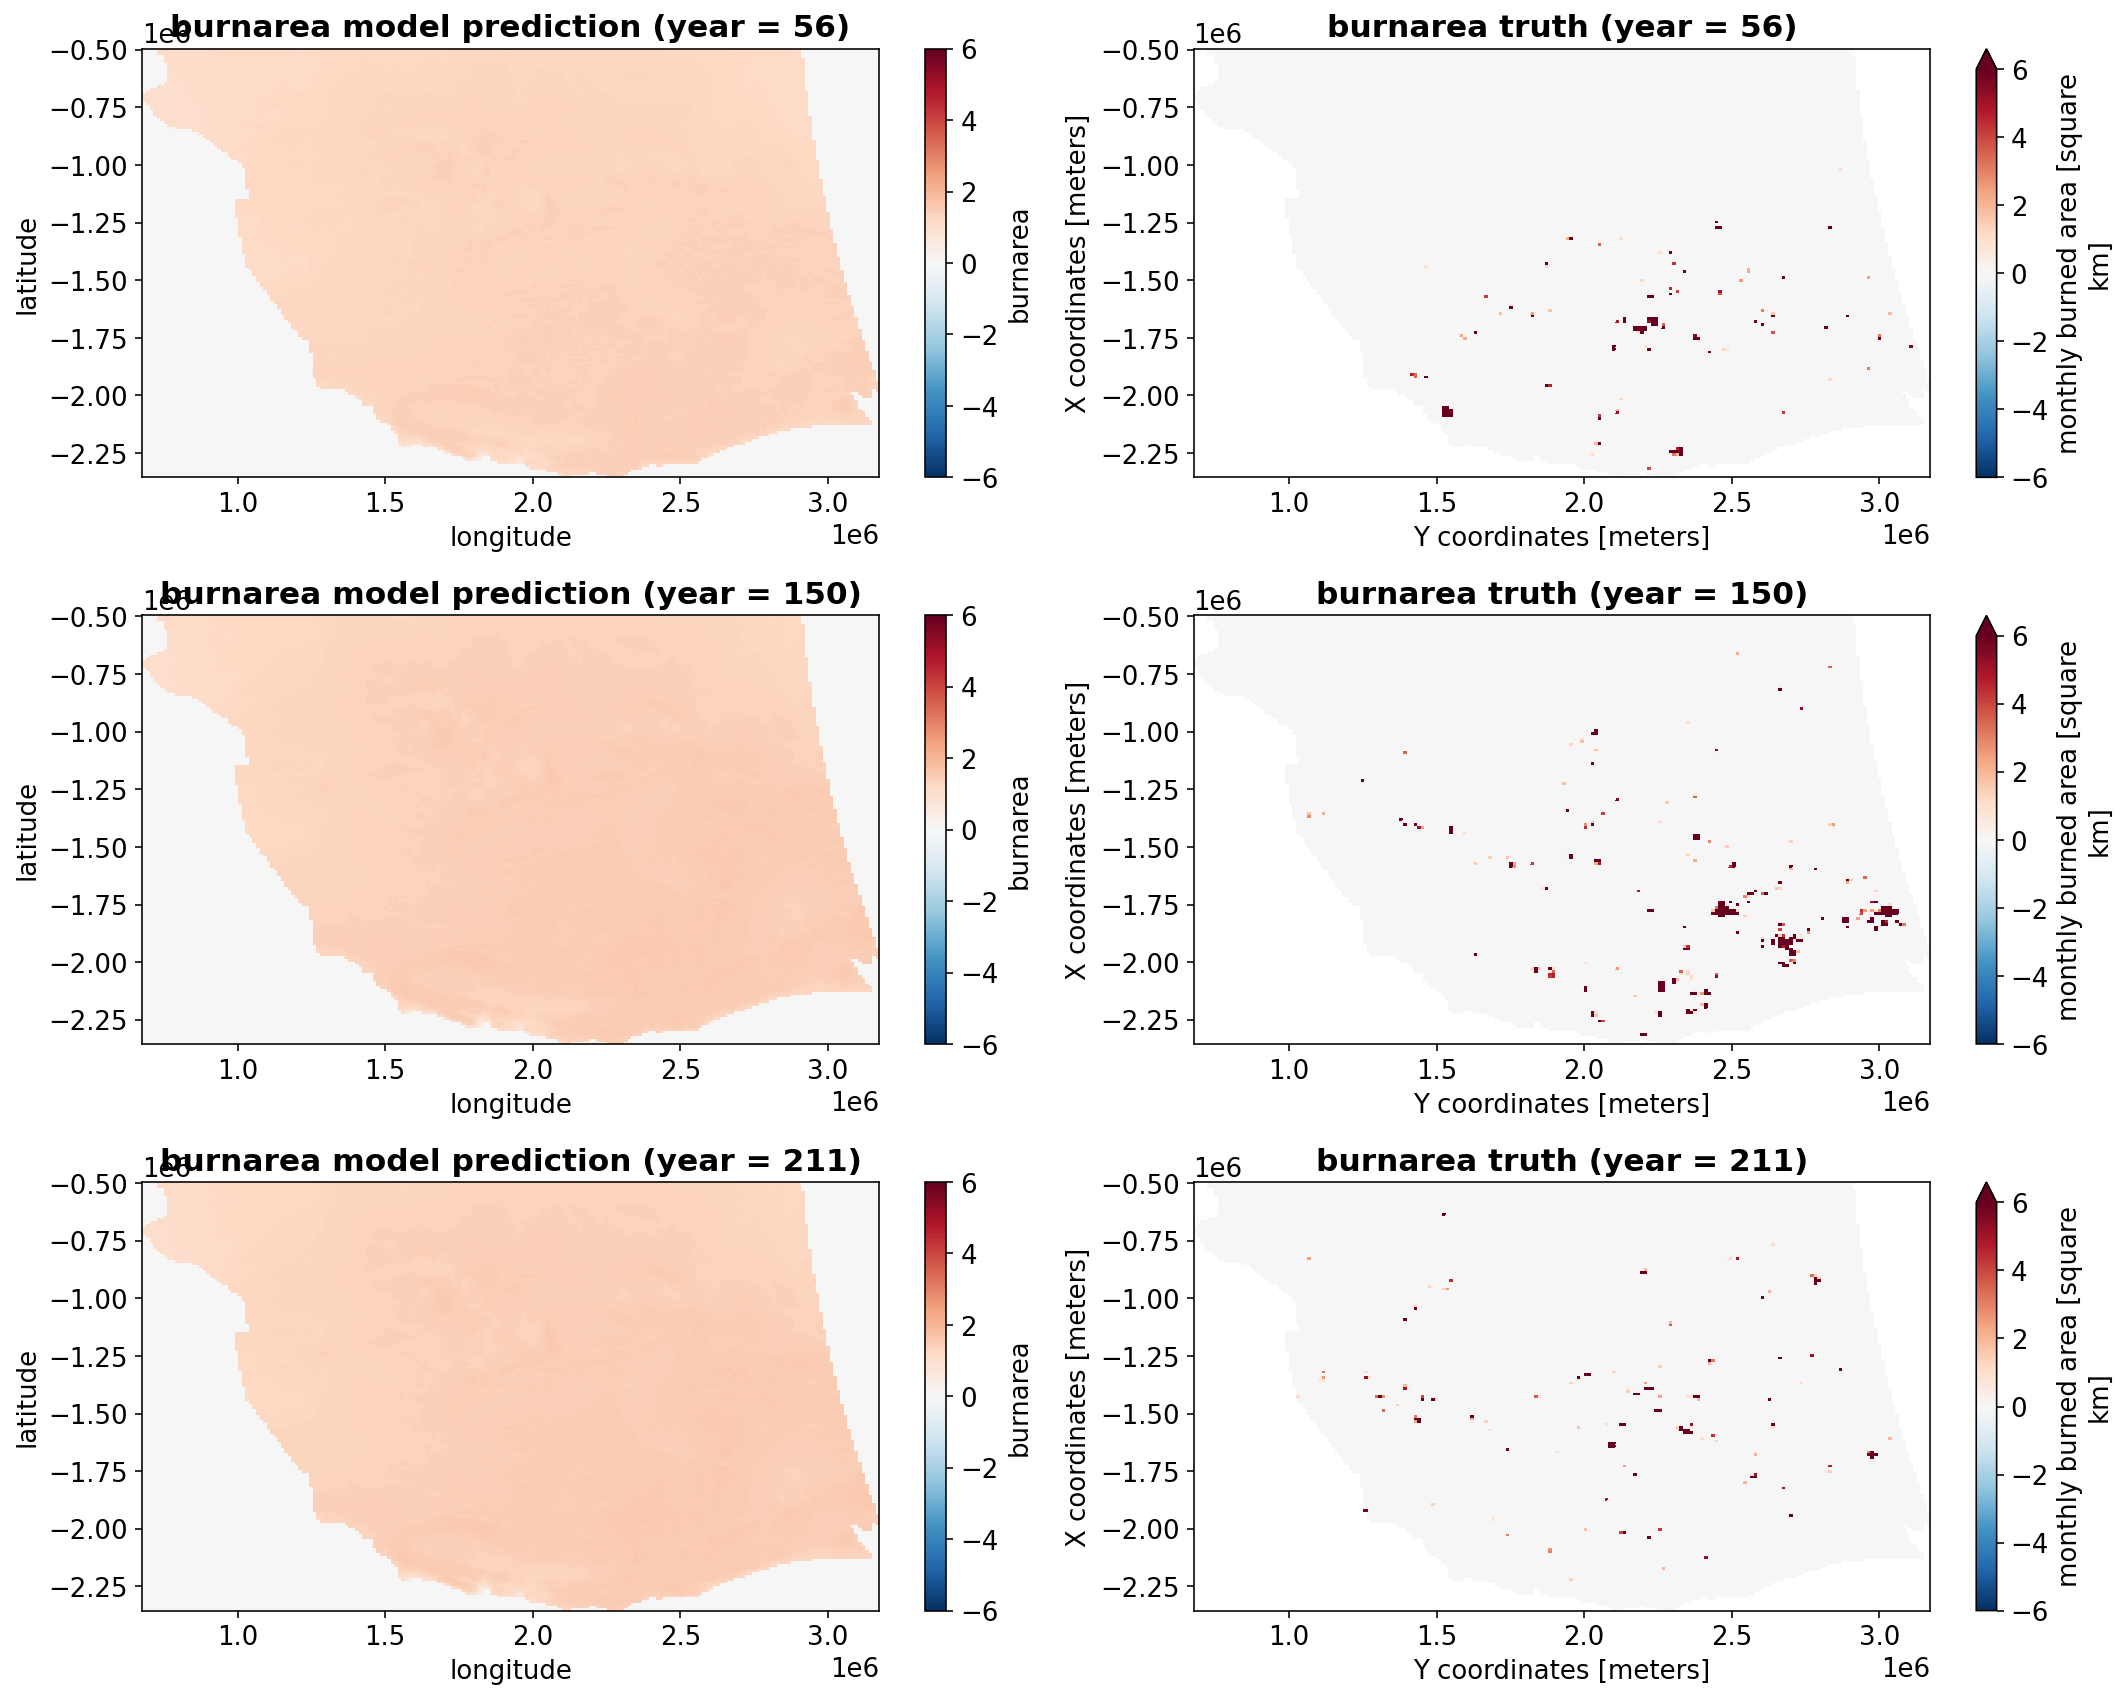

In [15]:
fig, axes = plt.subplots(figsize=(15,12), ncols=2, nrows=3)

yrs = [56, 150, 211]
vmin, vmax = -6, 6
cmap = 'RdBu_r'
y_test_pre.burnarea.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.burnarea.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.burnarea.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.burnarea.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.burnarea.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.burnarea.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'burnarea model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'burnarea truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()